In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

In [3]:
!pip install seaborn

In [ ]:
!pip install --user imblearn

In [ ]:
#conda install imbalanced-learn -c conda-forge

In [4]:
import pyeeg

In [5]:
from tensorflow import keras 

In [35]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\medha.ch\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\~rapt\\_wrappers.cp36-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached wrapt-1.12.1-py3-none-any.whl
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30693 sha256=0bd31a9c812194482b6d413ca7e7aa2d8c2738b03e942241a9583356ad68629f
  Stored in directory: c:\users\medha.ch\appdata\local\pip\cache\wheels\22\4c\94\0583f60c9c5b6024ed64f290cb2d43b06bb4f75577dc3c93a7
Successfully built clang
  Attempting uninstall: six
    Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.3.2
    Uninstalling google-auth-2.3.2:
      Successfully uninstalled google-auth-2.3.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.36.1
    Uninstalling grpcio-1.36.1:
    

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.15.0 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
tensorflow 1.15.0 requires tensorboard<1.16.0,>=1.15.0, but you have tensorboard 2.6.0 which is incompatible.
tensorflow 1.15.0 requires tensorflow-estimator==1.15.1, but you have tensorflow-estimator 2.6.0 which is incompatible.


  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached clang-5.0-py3-none-any.whl
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.1

In [6]:
%matplotlib inline

import glob
import math
import ntpath
import random, os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import edfreader
import models
import mne
#import pyeeg
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import joblib

from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, log_loss
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from xgboost import XGBClassifier
#import xgboost

# initializing variables

In [7]:
VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
batch_size = 64
number_of_subj = 50

# values to label the stages
UNKNOWN = -1
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4

# making string dictionary for the label values
label_dict = {
    "UNKNOWN"  : UNKNOWN,
    "W"        : W,
    "N1"       : N1,
    "N2"       : N2,
    "N3"       : N3,
    "REM"      : REM
}

# converting from label values to strings 
class_dict = {
    -1: "UNKNOWN",
    0 : "W",
    1 : "N1",
    2 : "N2",
    3 : "N3",
    4 : "REM"
}

# annotation dictionary to convert from string to label values
annot2label = {
    "Sleep stage ?": -1,
    "Movement time": -1,
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}
project_path = os.path.abspath(os.getcwd())  # finding the current project path in windows

# Localizing fetch_data function to import all subjects

In [6]:
# localized fetch_data function by using mne library
# https://github.com/mne-tools/mne-python/blob/maint/0.20/mne/datasets/sleep_physionet/age.py#L18-L111
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path, update_path=update_path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

In [6]:
!pip3 install ipywidgets --user

In [ ]:
#!jupyter nbextension enable --py widgetsnbextension

# Reading input data

In [7]:
subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data 
for i in range(83):
    if i in except_sub:
        continue
    subjects_list.append(i)
# fetching data of each subject and 
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)  
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

In [15]:
mne.__version__

'0.23.4'

# Sampling data and saving the results in NPZ format

In [16]:
ch_labels = 'EEG Fpz-Cz'  # channels to be selected
data_frames = []
if VBS:
    print("Importing data into dataframes:")
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
# loop to preprocess input data and save the results in npz files to be used in our models later
for item in tqdm(subject_files):
    filename = ntpath.basename(item[0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
        sampling_rate = raw_train.info['sfreq']
        #raw_ch_df = raw_train.to_data_frame(scaling_time=100.0)[ch_labels]
        raw_ch_df = raw_train.to_data_frame()[ch_labels]

        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))
        
        # reading the raw headers using the EDFReader function from edfreader
        f = open(item[0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read = edfreader.BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file
        f = open(item[1], 'r')
        annot_raw_read = edfreader.BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []
        
        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose anothe epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=np.int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x, 
            "y": y, 
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)

Importing data into dataframes:


  0%|          | 0/150 [00:00<?, ?it/s]

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creati

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4211E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4212E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4221E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4222E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4231E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creati

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4431E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4432E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4441E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4442E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4451F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creati

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4641E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4642E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4651E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4652E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4661E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creati

  0%|          | 0/20 [00:00<?, ?it/s]

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

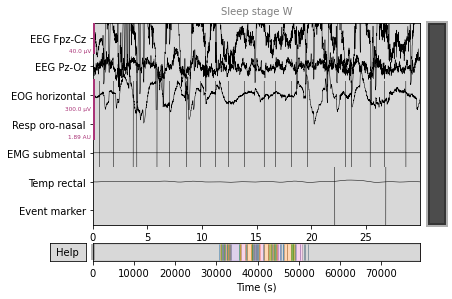

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


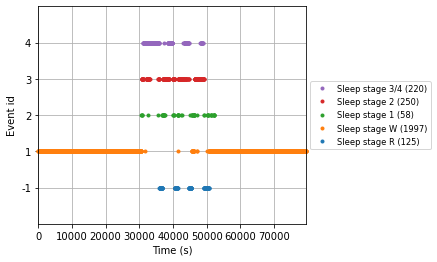

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

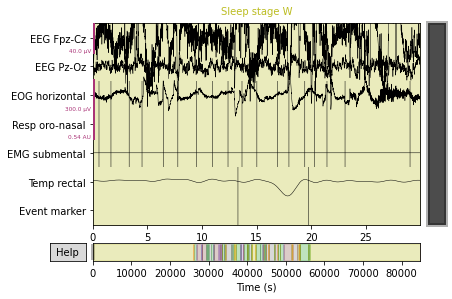

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


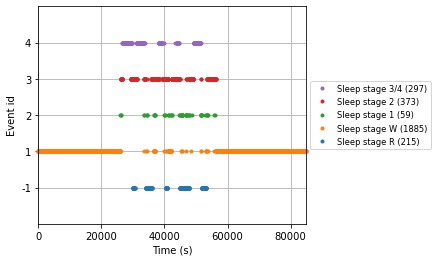

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

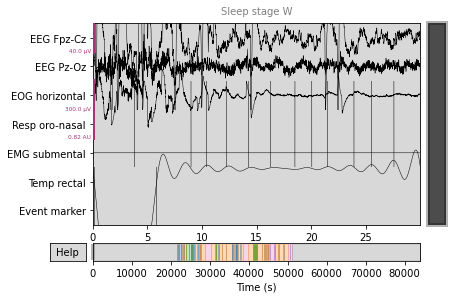

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


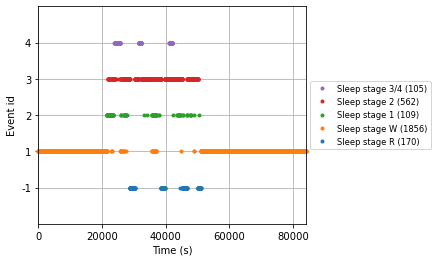

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

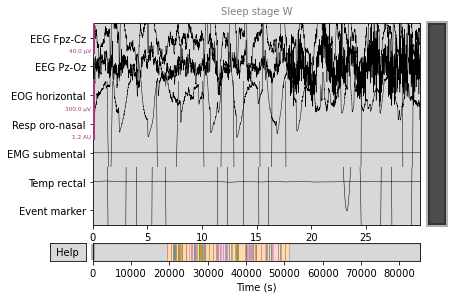

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


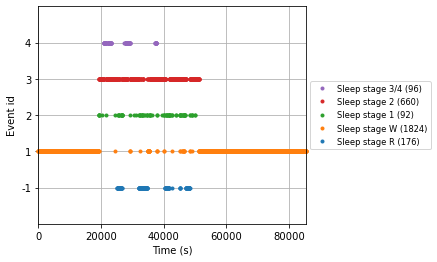

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

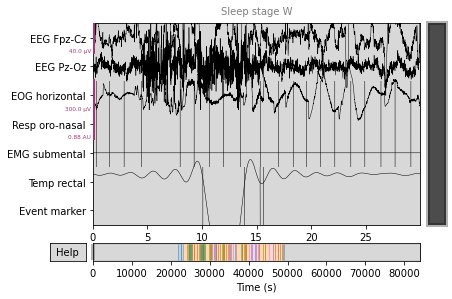

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


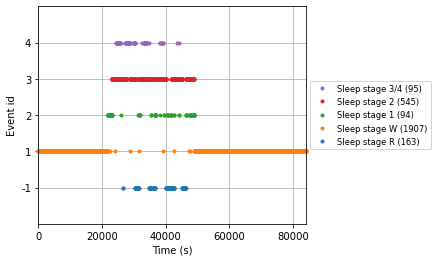

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

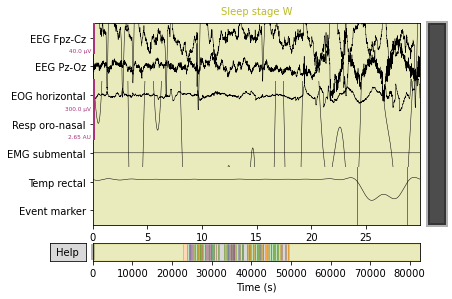

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


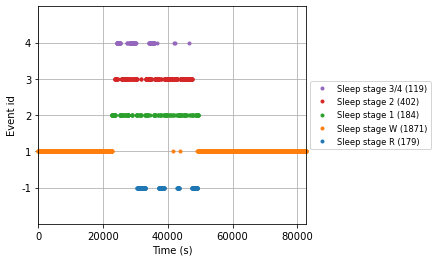

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

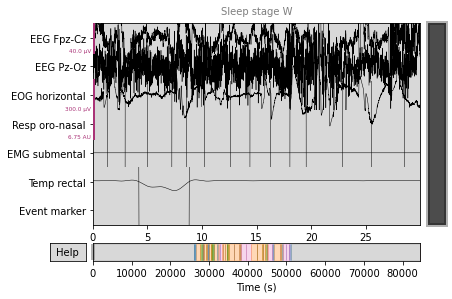

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


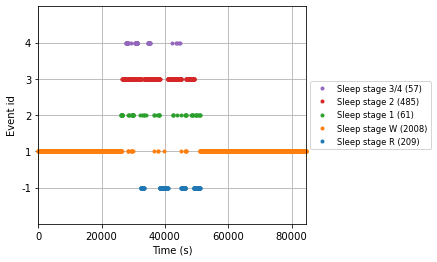

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

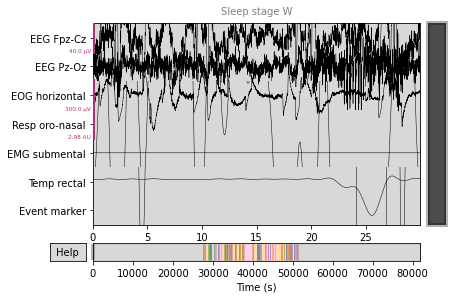

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


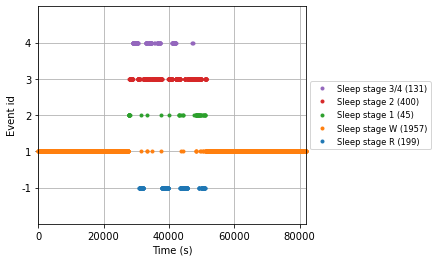

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

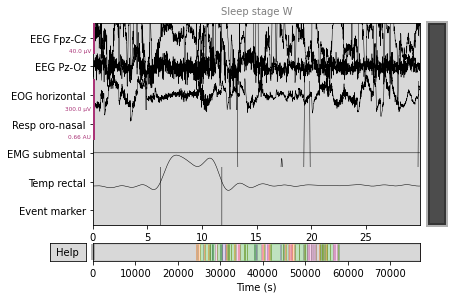

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']


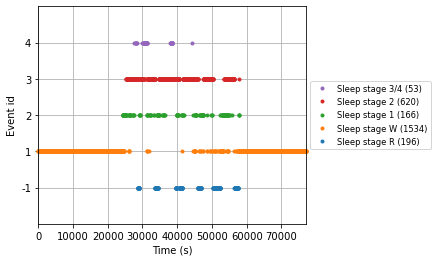

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

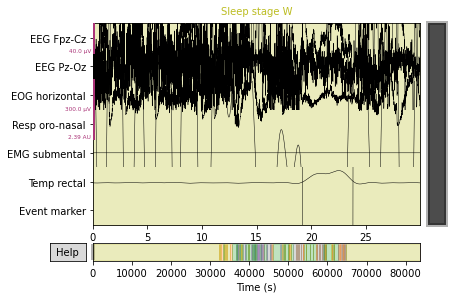

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


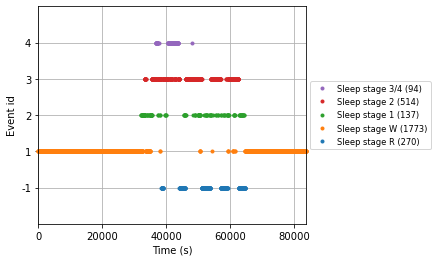

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

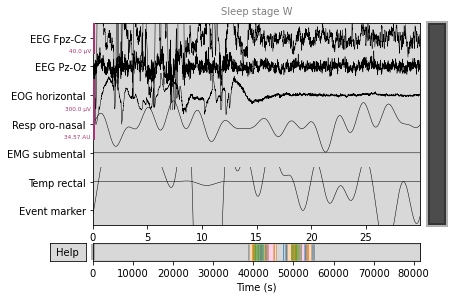

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


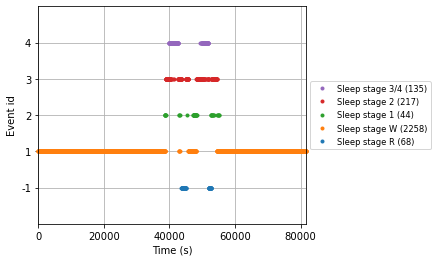

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

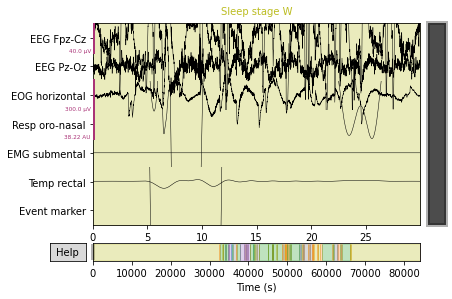

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


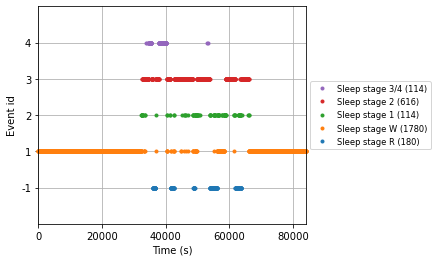

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

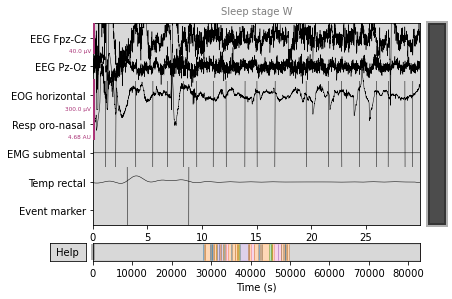

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


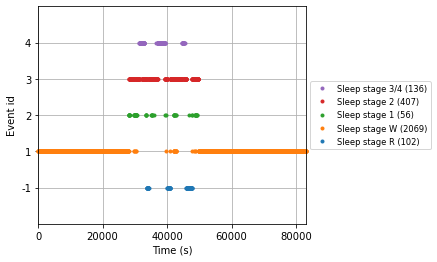

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4062E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

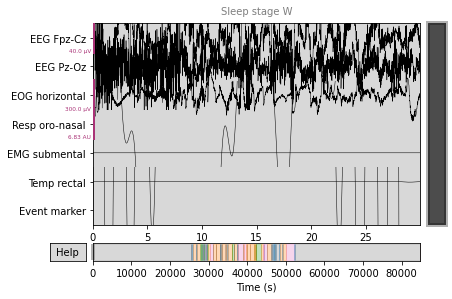

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


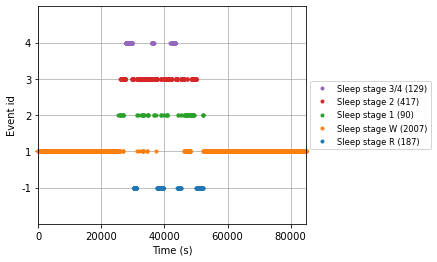

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

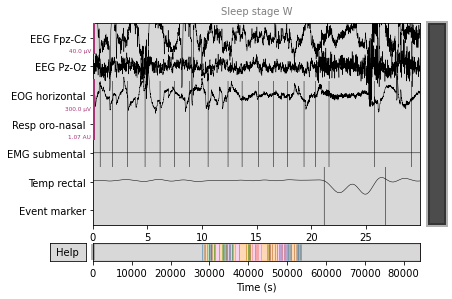

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


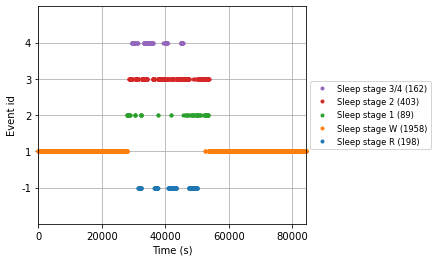

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

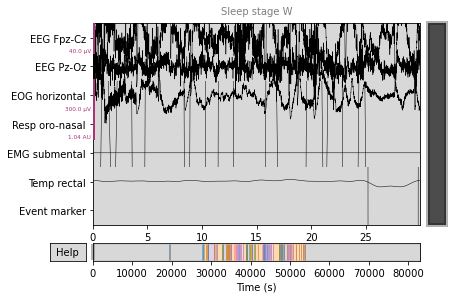

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


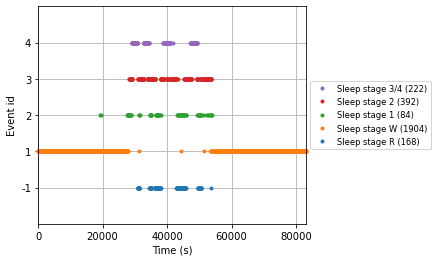

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

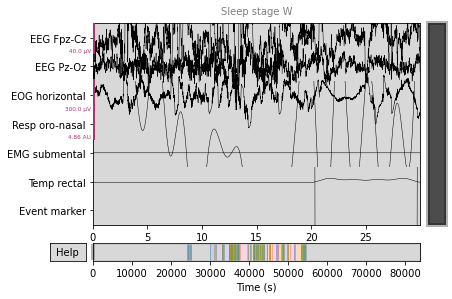

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


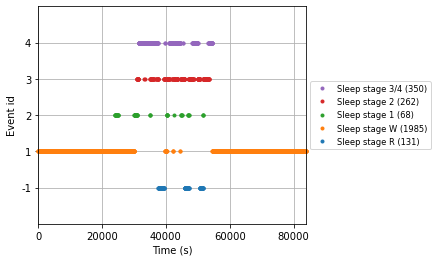

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

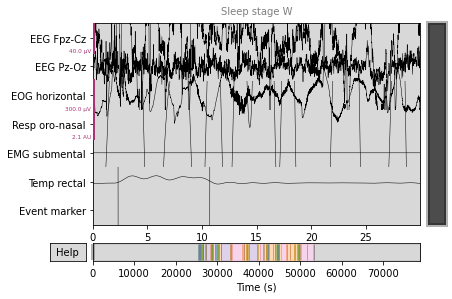

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


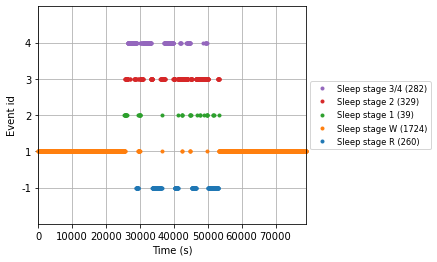

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4091E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

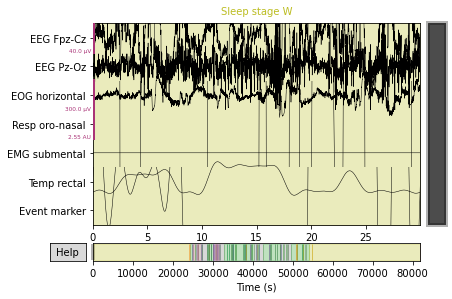

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


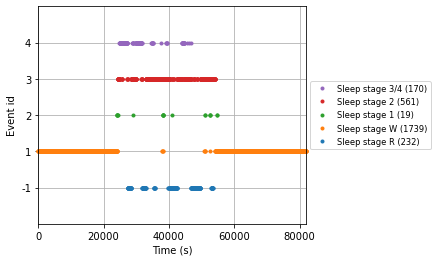

Extracting EDF parameters from E:\grad school\Thesis\jupyter_code\physionet_code\physionet-sleep-data\SC4092E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

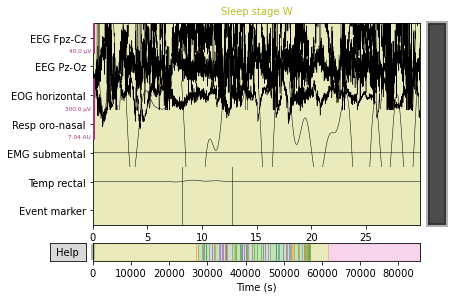

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


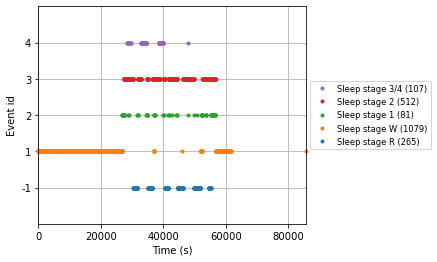

In [17]:
# plotting some of the subjects' raw signals and thier sleep stage
pdf_report = PdfPages('Sleep_Plots.pdf')
for item in tqdm(subject_files[:20]):  # selecting the first 20 subjects
    raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
    annot_train = mne.read_annotations(item[1])  # reading the hypnogram files

    raw_train.set_annotations(annot_train, emit_warning=False)
    raw_train.set_channel_types(mapping)
    figure = plt.figure()
    figure.suptitle("Subject: " + str(item[0][-13:-11]) + ", Night: " + str(item[0][-11:-10]))
    pdf_report.savefig(figure, papertype='a0', bbox_inches='tight')
    pdf_report.savefig(raw_train.plot(duration=30), papertype='a0', bbox_inches='tight')

    annotation_desc_2_event_id = {'Sleep stage R': -1,
                                  'Sleep stage W': 1,
                                  'Sleep stage 1': 2,
                                  'Sleep stage 2': 3,
                                  'Sleep stage 3': 4,
                                  'Sleep stage 4': 4
    }

    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage R'  : -1,
                'Sleep stage W'  : 1,
                'Sleep stage 1'  : 2,
                'Sleep stage 2'  : 3,
                'Sleep stage 3/4': 4
    }
    # plot events and saving them in PDF report
    pdf_report.savefig(mne.viz.plot_events(events_train, event_id=event_id,
                        sfreq=raw_train.info['sfreq']), bbox_inches='tight')
pdf_report.close()

In [19]:
!pip install hurst

In [8]:
from hurst import compute_Hc
Fs= 100
band_list = [0.5,4,7,12,30]
PSD = []  # Power Spectral Density
PFD = []  # Petrosian Fractal Dimension
hjorths = []  # Hjorth Parameters
hursts = []  # Hurst Exponent
DFA = []  # Detrended Fluctuation Analysis
for item in tqdm(subject_files[:5]):
    raw_test = mne.io.read_raw_edf(item[0], verbose=False)
    signals_list = raw_test[0][0][0]
    first_order = np.diff(signals_list).tolist()
    PSD.append(pyeeg.bin_power(signals_list, band_list, Fs))
    PFD.append(pyeeg.pfd(signals_list, first_order))
    hjorths.append(pyeeg.hjorth(signals_list, first_order))
    hursts.append(compute_Hc(signals_list, kind='change', min_window=100))
    DFA.append(pyeeg.dfa(signals_list))

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
PSD

[(array([45949.45275709, 13512.33271143, 10422.91549854, 21885.64291393]),
  array([0.50070045, 0.14724073, 0.11357608, 0.23848274])),
 (array([55703.28687037, 17821.89367959, 16493.32421444, 41763.95633838]),
  array([0.4226912 , 0.13523722, 0.12515569, 0.31691589])),
 (array([54270.5998687 , 12827.02509286,  8761.34064108, 13002.52756592]),
  array([0.61073248, 0.14434852, 0.09859547, 0.14632353])),
 (array([56090.22689488, 14660.24231835,  9737.75600789, 14692.92037319]),
  array([0.58929977, 0.15402465, 0.10230762, 0.15436797])),
 (array([31865.96183446,  7583.84826247,  6047.82470754, 12376.48706137]),
  array([0.55060813, 0.1310404 , 0.10449964, 0.21385183]))]

In [10]:
PFD 

[0.5260813226365344,
 0.524797335166937,
 0.5296215973392818,
 0.5294222017464901,
 0.5267916487609091]

In [11]:
hjorths

[(0.0001242622534516733, 13143.036280788516),
 (0.00018132418018598445, 9335.362942673955),
 (5.907335927673209e-05, 20875.12130562849),
 (6.000383534000729e-05, 21344.445095750732),
 (9.11423315792555e-05, 17072.109438632604)]

In [12]:
hursts

[(0.5835558023705112,
  1.9675214804449506,
  [[100,
    177,
    316,
    562,
    1000,
    1778,
    3162,
    5623,
    10000,
    17782,
    31622,
    56234,
    100000,
    177827,
    316227,
    562341,
    1000000,
    1778279,
    3162277,
    5623413,
    7950000],
   [66.155289324895,
    78.03278176625084,
    92.8269827023827,
    109.1797641429729,
    127.685467256491,
    148.35310840475495,
    170.87570151326753,
    199.11435939199475,
    236.607566194322,
    295.30064301639317,
    401.0119507395091,
    567.6520016324292,
    867.8478412872066,
    1371.6178989154598,
    2278.0002184751975,
    3883.461386368686,
    6822.7929886229895,
    12014.181321928756,
    20799.87686140842,
    36924.673078698506,
    51012.429228018846]]),
 (0.7424666912558766,
  0.7598713480125574,
  [[100,
    177,
    316,
    562,
    1000,
    1778,
    3162,
    5623,
    10000,
    17782,
    31622,
    56234,
    100000,
    177827,
    316227,
    562341,
    1000000,
    17

In [13]:
DFA

[0.13913468824876388,
 0.23940635037879304,
 0.19817581210315935,
 0.20098505597555377,
 0.19821142314924287]

In [15]:
output_path = os.path.join(project_path, "NPZ_files") #run this if .npz were already created using the previous piece of code

In [16]:
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 1))
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
X

array([[[  8.11135578],
        [ 17.48864555],
        [ 21.23956108],
        ...,
        [-10.3619051 ],
        [-11.1120882 ],
        [ -2.10989022]],

       [[-10.73699665],
        [-11.39340687],
        [ -4.45421267],
        ...,
        [ 58.84249115],
        [ 48.33992767],
        [ 53.6849823 ]],

       [[ 61.37435913],
        [ 38.68132019],
        [ 49.55897522],
        ...,
        [ 33.61758423],
        [ 34.36776733],
        [ 31.83589745]],

       ...,

       [[ -0.59584862],
        [  0.36849818],
        [  0.45616606],
        ...,
        [ -1.03418803],
        [ -1.4725275 ],
        [ -1.9985348 ]],

       [[  1.15750921],
        [  2.91086698],
        [  1.24517703],
        ...,
        [ -5.24224663],
        [ -5.06691074],
        [ -4.10256433]],

       [[ -7.08327246],
        [ -5.68058586],
        [ -4.45323563],
        ...,
        [ 12.90500641],
        [  9.83662987],
        [  8.6969471 ]]])

In [18]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
if VBS:
    print("Petrosian Fractal Dimension (PFD): ", PFD)
    print("Hjorth mobility and complexity: ", hjorths)
    print("Detrended Fluctuation Analysis (DFA): ", DFA)
    print("Hurst Exponent (Hurst): ", hursts)

Petrosian Fractal Dimension (PFD):  [0.5260813226365344, 0.524797335166937, 0.5296215973392818, 0.5294222017464901, 0.5267916487609091]
Hjorth mobility and complexity:  [(0.0001242622534516733, 13143.036280788516), (0.00018132418018598445, 9335.362942673955), (5.907335927673209e-05, 20875.12130562849), (6.000383534000729e-05, 21344.445095750732), (9.11423315792555e-05, 17072.109438632604)]
Detrended Fluctuation Analysis (DFA):  [0.13913468824876388, 0.23940635037879304, 0.19817581210315935, 0.20098505597555377, 0.19821142314924287]
Hurst Exponent (Hurst):  [(0.5835558023705112, 1.9675214804449506, [[100, 177, 316, 562, 1000, 1778, 3162, 5623, 10000, 17782, 31622, 56234, 100000, 177827, 316227, 562341, 1000000, 1778279, 3162277, 5623413, 7950000], [66.155289324895, 78.03278176625084, 92.8269827023827, 109.1797641429729, 127.685467256491, 148.35310840475495, 170.87570151326753, 199.11435939199475, 236.607566194322, 295.30064301639317, 401.0119507395091, 567.6520016324292, 867.84784128720

Text(0.5, 1.0, 'Frequency of the labels in our dataset')

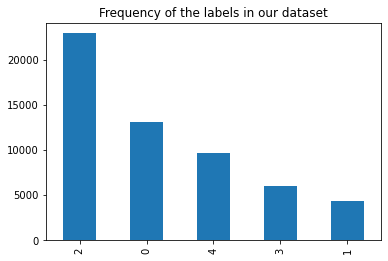

In [20]:
pd.Series(y).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

In [21]:
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
# splitting sleeping signals
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)
if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest_dataset: {}\n"
          .format(X_train.shape, X_test.shape))
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

# X_train = np.squeeze(X_train)
# X_test = np.squeeze(X_test)
# X_val = np.squeeze(X_val)

Shape of the input data: (55989, 3000, 1)
Shape of the sleep stages: (55989,)
Shape of the training dataset:
training dataset: (45351, 3000, 1)
test_dataset: (5599, 3000, 1)



# CNN

In [43]:
#from tensorflow.python.eager.context import get_config

ImportError: cannot import name 'get_config'

In [15]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.optimizers import Adam
#from keras_contrib.layers import CRF

from scipy.signal import butter, lfilter


In [16]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras_contrib.layers import CRF

from scipy.signal import butter, lfilter


In [17]:
#n_classes=5
def model_b(n_classes=5, use_sub_layer=False, use_rnn=True, verbose=False):
    inputLayer = Input(shape=(3000, 1), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.get_shape()
    convFine = Flatten(name='fFlat1')(convFine)
    
    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.get_shape()
    convCoarse = Flatten(name='cFlat1')(convCoarse)
    
    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    
    outLayer = Reshape((1, outLayer.get_shape()[1]), name='reshape1')(outLayer)
    outLayer = LSTM(64, return_sequences=True)(outLayer)
    outLayer = LSTM(64, return_sequences=False)(outLayer)

    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    if verbose:
        model.summary()
    return model

In [18]:
def butter_bandpass(lowcut, highpass, fs, order=4):
    nyq = 0.5 * fs
    #       low = lowcut / nyq
    high = highpass / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a

In [19]:
def butter_bandpass_filter(data, highpass, fs, order=4):
    b, a = butter_bandpass(0, highpass, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [53]:
pp_X_train = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])
# pp_X_test = np.expand_dims(pp_X_test, axis=2)
# pp_X_train = np.expand_dims(pp_X_train, axis=2)
# pp_X_val = np.expand_dims(pp_X_val, axis=2)
if VBS:
    print(pp_X_val.shape)
    print(pp_X_train.shape)

(5039, 3000, 1)
(45351, 3000, 1)


In [54]:
checkpoint = ModelCheckpoint("model_cps", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
    redonplat,
    csv_logger,
]

In [56]:
model_cnn = model_b(verbose=VBS)
hist_19 = model_cnn.fit(
    pp_X_train, y_train_, batch_size=batch_size, epochs=30, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list, verbose=VBS
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inLayer (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
fConv1 (Conv1D)                 (None, 500, 64)      3264        inLayer[0][0]                    
__________________________________________________________________________________________________
cConv1 (Conv1D)                 (None, 60, 32)       12832       inLayer[0][0]                    
__________________________________________________________________________________________________
fMaxP1 (MaxPooling1D)           (None, 62, 64)       0           fConv1[0][0]                     
_____________

Epoch 9/30
45312/45351 [============================>.] - ETA: 0s - loss: 0.4758 - acc: 0.8228
Epoch 00009: val_loss did not improve from 0.74670
45351/45351 [==============================] - 167s 4ms/sample - loss: 0.4759 - acc: 0.8228 - val_loss: 0.4732 - val_acc: 0.8238
Epoch 10/30
45312/45351 [============================>.] - ETA: 0s - loss: 0.4736 - acc: 0.8231
Epoch 00010: val_loss did not improve from 0.74670
45351/45351 [==============================] - 166s 4ms/sample - loss: 0.4734 - acc: 0.8232 - val_loss: 0.4698 - val_acc: 0.8262
Epoch 11/30
45312/45351 [============================>.] - ETA: 0s - loss: 0.4698 - acc: 0.8250
Epoch 00011: val_loss did not improve from 0.74670

Epoch 00011: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
45351/45351 [==============================] - 166s 4ms/sample - loss: 0.4700 - acc: 0.8249 - val_loss: 0.4662 - val_acc: 0.8258
Epoch 12/30
45312/45351 [============================>.] - ETA: 0s - loss: 0.4695 - acc: 0.8

In [57]:
y_pred = model_cnn.predict(pp_X_test, batch_size=batch_size)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1_cnn = f1_score(y_test, y_pred, average="macro")
if VBS:
    print("F1 score: {}".format(f1_cnn))
    report = classification_report(y_test, y_pred)
    print(report)

F1 score: 0.7229519182238868
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1231
           1       0.48      0.14      0.22       435
           2       0.89      0.86      0.87      2341
           3       0.88      0.85      0.86       613
           4       0.64      0.88      0.74       979

    accuracy                           0.82      5599
   macro avg       0.76      0.73      0.72      5599
weighted avg       0.82      0.82      0.81      5599



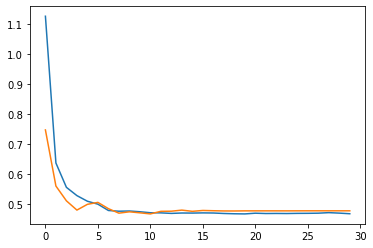

In [58]:
plt.plot(hist_19.history["loss"])
plt.plot(hist_19.history["val_loss"])

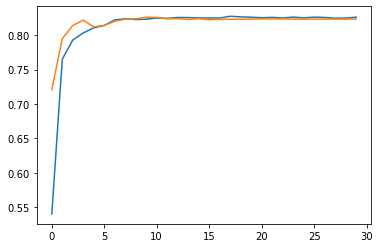

In [59]:
plt.plot(hist_19.history["acc"])
plt.plot(hist_19.history["val_acc"])

# RF classifier

In [38]:
X.shape

(55989, 3000, 1)

In [39]:
x_rshp=X.reshape(55989,3000)

In [40]:
x_rshp

array([[  8.11135578,  17.48864555,  21.23956108, ..., -10.3619051 ,
        -11.1120882 ,  -2.10989022],
       [-10.73699665, -11.39340687,  -4.45421267, ...,  58.84249115,
         48.33992767,  53.6849823 ],
       [ 61.37435913,  38.68132019,  49.55897522, ...,  33.61758423,
         34.36776733,  31.83589745],
       ...,
       [ -0.59584862,   0.36849818,   0.45616606, ...,  -1.03418803,
         -1.4725275 ,  -1.9985348 ],
       [  1.15750921,   2.91086698,   1.24517703, ...,  -5.24224663,
         -5.06691074,  -4.10256433],
       [ -7.08327246,  -5.68058586,  -4.45323563, ...,  12.90500641,
          9.83662987,   8.6969471 ]])

In [22]:
X_train.shape

(45351, 3000, 1)

In [23]:
y_train.shape

(45351,)

In [24]:
x_train_rshp=X_train.reshape(45351,3000)

In [25]:
x_train_rshp

array([[ 11.54700851,  13.90354061,   8.71916962, ...,   4.10036612,
          2.21514034,   7.68229532],
       [ -2.48351645,  14.35433483,  11.62148952, ..., -14.64908409,
         -6.53870583, -20.1147747 ],
       [-68.46154022, -66.63589478, -41.42466354, ..., -28.99291801,
        -26.12405396, -30.55775261],
       ...,
       [-11.59706974, -11.5086689 , -11.42026901, ..., -26.09474945,
        -24.59194183, -19.55311394],
       [-10.38461494, -10.9384613 , -11.12307739, ...,  -7.3384614 ,
         -7.15384626,  -6.69230747],
       [-15.57509136, -16.01709366, -17.43150139, ...,  25.53113556,
         11.3870573 ,  10.23785114]])

In [28]:
x_test_rshp=X_test.reshape(5599,3000)

In [29]:
y_test.shape

(5599,)

In [26]:
rf=RandomForestClassifier()

In [27]:
rf.fit(x_train_rshp,y_train)

RandomForestClassifier()

In [30]:
predictions_rf=rf.predict(x_test_rshp)

In [32]:
predictions_rf

array([2, 2, 2, ..., 2, 2, 2])

In [33]:
report = classification_report(y_test, predictions_rf)

In [35]:
print(report)

              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1231
           1       0.00      0.00      0.00       435
           2       0.55      0.91      0.68      2341
           3       0.80      0.28      0.42       613
           4       0.44      0.13      0.20       979

    accuracy                           0.55      5599
   macro avg       0.47      0.37      0.37      5599
weighted avg       0.52      0.55      0.49      5599



# saving the reshaped X (x_rshp) to csv file

In [41]:
x_rshp

array([[  8.11135578,  17.48864555,  21.23956108, ..., -10.3619051 ,
        -11.1120882 ,  -2.10989022],
       [-10.73699665, -11.39340687,  -4.45421267, ...,  58.84249115,
         48.33992767,  53.6849823 ],
       [ 61.37435913,  38.68132019,  49.55897522, ...,  33.61758423,
         34.36776733,  31.83589745],
       ...,
       [ -0.59584862,   0.36849818,   0.45616606, ...,  -1.03418803,
         -1.4725275 ,  -1.9985348 ],
       [  1.15750921,   2.91086698,   1.24517703, ...,  -5.24224663,
         -5.06691074,  -4.10256433],
       [ -7.08327246,  -5.68058586,  -4.45323563, ...,  12.90500641,
          9.83662987,   8.6969471 ]])

In [42]:
x_rshp.shape

(55989, 3000)

In [44]:
x_rshp_df=pd.DataFrame(x_rshp)

In [45]:
x_rshp_df

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,8.111356,17.488646,21.239561,6.892308,9.424176,5.485714,1.734799,0.234432,-1.359707,1.922344,...,-13.268865,-7.079854,0.328205,-11.862271,-8.580220,-4.923077,0.515751,-10.361905,-11.112088,-2.109890
1,-10.736997,-11.393407,-4.454213,-0.234432,-3.422711,-23.677656,-11.768498,-17.769964,-23.490110,-16.269598,...,53.966301,54.904030,41.025642,55.372894,54.904030,64.750183,52.090843,58.842491,48.339928,53.684982
2,61.374359,38.681320,49.558975,53.872528,62.780952,65.687912,56.498169,58.373627,45.714287,54.997803,...,38.868866,34.086449,30.335531,36.524544,36.618317,30.991941,33.898903,33.617584,34.367767,31.835897
3,27.803663,24.146521,24.146521,14.581685,13.831502,7.736264,6.423443,8.205129,4.923077,4.172894,...,-20.864470,-18.051283,-8.486447,2.016117,7.267399,26.865934,9.424176,26.303297,42.619781,56.967033
4,69.157509,74.596336,79.003662,80.035164,77.409523,77.315750,74.783882,76.096703,74.596336,79.191208,...,-30.804396,-25.271795,-12.612454,0.140659,12.518682,9.424176,17.488646,11.956044,25.365568,42.994873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55984,4.138217,5.453236,-1.121856,2.998535,0.982173,-2.261539,2.209524,10.800977,-1.297192,-19.970451,...,1.245177,5.628572,7.031258,6.505250,5.716239,5.190232,5.716239,10.450305,11.063980,13.869353
55985,12.905006,13.694017,11.151649,8.433944,3.962882,2.472528,14.746032,-13.307693,-2.173871,1.420513,...,10.187302,8.784616,3.962882,5.540904,12.203663,7.031258,2.647863,5.540904,5.891575,-2.349206
55986,-0.595849,0.368498,0.456166,2.297192,1.420513,-3.927228,-4.453236,-7.696948,-1.560195,-3.313553,...,4.225885,7.732601,2.121856,2.735531,2.384860,1.683517,-4.277900,-1.034188,-1.472528,-1.998535
55987,1.157509,2.910867,1.245177,1.858852,-0.771184,2.560195,3.524542,6.329915,5.365568,1.069841,...,-5.943590,-10.063980,-2.962882,10.450305,-22.512821,-11.729671,0.280830,-5.242247,-5.066911,-4.102564


In [46]:
x_rshp_df['sleep_stage']=y

In [47]:
x_rshp_df

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,sleep_stage
0,8.111356,17.488646,21.239561,6.892308,9.424176,5.485714,1.734799,0.234432,-1.359707,1.922344,...,-7.079854,0.328205,-11.862271,-8.580220,-4.923077,0.515751,-10.361905,-11.112088,-2.109890,0
1,-10.736997,-11.393407,-4.454213,-0.234432,-3.422711,-23.677656,-11.768498,-17.769964,-23.490110,-16.269598,...,54.904030,41.025642,55.372894,54.904030,64.750183,52.090843,58.842491,48.339928,53.684982,0
2,61.374359,38.681320,49.558975,53.872528,62.780952,65.687912,56.498169,58.373627,45.714287,54.997803,...,34.086449,30.335531,36.524544,36.618317,30.991941,33.898903,33.617584,34.367767,31.835897,0
3,27.803663,24.146521,24.146521,14.581685,13.831502,7.736264,6.423443,8.205129,4.923077,4.172894,...,-18.051283,-8.486447,2.016117,7.267399,26.865934,9.424176,26.303297,42.619781,56.967033,0
4,69.157509,74.596336,79.003662,80.035164,77.409523,77.315750,74.783882,76.096703,74.596336,79.191208,...,-25.271795,-12.612454,0.140659,12.518682,9.424176,17.488646,11.956044,25.365568,42.994873,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55984,4.138217,5.453236,-1.121856,2.998535,0.982173,-2.261539,2.209524,10.800977,-1.297192,-19.970451,...,5.628572,7.031258,6.505250,5.716239,5.190232,5.716239,10.450305,11.063980,13.869353,0
55985,12.905006,13.694017,11.151649,8.433944,3.962882,2.472528,14.746032,-13.307693,-2.173871,1.420513,...,8.784616,3.962882,5.540904,12.203663,7.031258,2.647863,5.540904,5.891575,-2.349206,0
55986,-0.595849,0.368498,0.456166,2.297192,1.420513,-3.927228,-4.453236,-7.696948,-1.560195,-3.313553,...,7.732601,2.121856,2.735531,2.384860,1.683517,-4.277900,-1.034188,-1.472528,-1.998535,0
55987,1.157509,2.910867,1.245177,1.858852,-0.771184,2.560195,3.524542,6.329915,5.365568,1.069841,...,-10.063980,-2.962882,10.450305,-22.512821,-11.729671,0.280830,-5.242247,-5.066911,-4.102564,0


In [48]:
x_rshp_df.to_csv(r'E:/grad school/Thesis/jupyter_code/physionet_code/physionet_csvs/first_fifty_subs_physionet.csv', header=False, index=False)

In [5]:
full_data=pd.read_csv('E:/grad school/Thesis/jupyter_code/physionet_code/physionet_csvs/first_fifty_subs_physionet.csv', header=None)

In [6]:
full_data

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,8.111356,17.488646,21.239561,6.892308,9.424176,5.485714,1.734799,0.234432,-1.359707,1.922344,...,-7.079854,0.328205,-11.862271,-8.580220,-4.923077,0.515751,-10.361905,-11.112088,-2.109890,0
1,-10.736997,-11.393407,-4.454213,-0.234432,-3.422711,-23.677656,-11.768498,-17.769964,-23.490110,-16.269598,...,54.904030,41.025642,55.372894,54.904030,64.750183,52.090843,58.842491,48.339928,53.684982,0
2,61.374359,38.681320,49.558975,53.872528,62.780952,65.687912,56.498169,58.373627,45.714287,54.997803,...,34.086449,30.335531,36.524544,36.618317,30.991941,33.898903,33.617584,34.367767,31.835897,0
3,27.803663,24.146521,24.146521,14.581685,13.831502,7.736264,6.423443,8.205129,4.923077,4.172894,...,-18.051283,-8.486447,2.016117,7.267399,26.865934,9.424176,26.303297,42.619781,56.967033,0
4,69.157509,74.596336,79.003662,80.035164,77.409523,77.315750,74.783882,76.096703,74.596336,79.191208,...,-25.271795,-12.612454,0.140659,12.518682,9.424176,17.488646,11.956044,25.365568,42.994873,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55984,4.138217,5.453236,-1.121856,2.998535,0.982173,-2.261539,2.209524,10.800977,-1.297192,-19.970451,...,5.628572,7.031258,6.505250,5.716239,5.190232,5.716239,10.450305,11.063980,13.869353,0
55985,12.905006,13.694017,11.151649,8.433944,3.962882,2.472528,14.746032,-13.307693,-2.173871,1.420513,...,8.784616,3.962882,5.540904,12.203663,7.031258,2.647863,5.540904,5.891575,-2.349206,0
55986,-0.595849,0.368498,0.456166,2.297192,1.420513,-3.927228,-4.453236,-7.696948,-1.560195,-3.313553,...,7.732601,2.121856,2.735531,2.384860,1.683517,-4.277900,-1.034188,-1.472528,-1.998535,0
55987,1.157509,2.910867,1.245177,1.858852,-0.771184,2.560195,3.524542,6.329915,5.365568,1.069841,...,-10.063980,-2.962882,10.450305,-22.512821,-11.729671,0.280830,-5.242247,-5.066911,-4.102564,0


In [7]:
full_data_cp=full_data.copy()

In [8]:
dt_shuf1=full_data_cp.sample(frac=1,replace=True, random_state=991)

In [9]:
dt_shuf1

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
22446,1.769231,5.153846,11.358974,15.589744,16.341881,11.452991,7.880342,-0.487179,-5.752137,-1.521368,...,14.461538,7.128205,6.094017,4.589744,9.572650,0.641026,6.846154,0.735043,0.923077,2
2992,-1.843223,-2.640293,0.647619,3.138462,1.444689,-3.337729,-1.444689,-2.042491,-4.334066,-10.013186,...,12.802931,12.404396,10.013186,6.526007,4.234432,3.337729,4.234432,2.441026,0.747253,4
37536,-7.057143,-3.971429,-6.457143,1.342857,-8.514286,1.085714,-1.400000,-0.628571,-2.428571,3.485714,...,16.514286,13.171429,9.057143,15.314285,22.685715,18.828571,20.542856,24.400000,21.657143,0
49751,-11.901832,8.236875,-13.041759,15.076435,-6.487179,10.801709,-14.941636,13.556532,-12.091820,13.461538,...,-43.724785,-5.632235,-41.444931,-3.447375,-43.914776,0.257387,-40.969963,-0.787546,-49.994385,0
55894,-19.707449,-19.970451,-19.181440,-18.655434,-21.548473,-19.444445,-21.110134,-22.775824,-21.636141,-18.743101,...,8.872283,8.609280,7.907937,5.190232,7.907937,9.485958,12.992674,13.518682,15.885715,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,-3.636630,-5.529670,-2.839561,-2.341392,-1.345055,-2.441026,-1.743590,-0.747253,-0.647619,-4.334066,...,4.732601,4.732601,2.341392,0.249084,-2.341392,-7.821245,-12.603663,-16.489378,-15.194139,2
7552,-25.133333,-21.762394,-7.088889,5.998291,5.205128,-0.842735,-20.473505,-30.388035,-25.331623,-7.981196,...,32.073505,9.468376,-17.895727,-21.365812,-11.847863,6.494017,9.468376,6.295726,-2.726496,2
8971,-3.063492,-5.420024,-2.309402,-7.022467,-7.776557,-9.284738,-9.001954,-8.530647,-9.473260,-16.354334,...,2.874969,5.608547,5.608547,1.084005,-2.215140,2.686447,9.473260,7.776557,0.706960,1
28687,-0.999756,0.043468,-0.825885,-1.173626,-2.651526,-2.825397,-9.606349,-3.781685,-6.998291,-2.390720,...,-12.822955,6.737485,-38.381927,23.515995,20.821001,-8.997802,19.864714,16.821978,-45.684494,4


In [30]:
type(dt_shuf1)

pandas.core.frame.DataFrame

In [20]:
x_shuf1=dt_shuf1.drop([3000],axis=1)
y_shuf1=dt_shuf1[3000]

In [21]:
x_shuf1

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
22446,1.769231,5.153846,11.358974,15.589744,16.341881,11.452991,7.880342,-0.487179,-5.752137,-1.521368,...,3.085470,14.461538,7.128205,6.094017,4.589744,9.572650,0.641026,6.846154,0.735043,0.923077
2992,-1.843223,-2.640293,0.647619,3.138462,1.444689,-3.337729,-1.444689,-2.042491,-4.334066,-10.013186,...,6.326740,12.802931,12.404396,10.013186,6.526007,4.234432,3.337729,4.234432,2.441026,0.747253
37536,-7.057143,-3.971429,-6.457143,1.342857,-8.514286,1.085714,-1.400000,-0.628571,-2.428571,3.485714,...,18.400000,16.514286,13.171429,9.057143,15.314285,22.685715,18.828571,20.542856,24.400000,21.657143
49751,-11.901832,8.236875,-13.041759,15.076435,-6.487179,10.801709,-14.941636,13.556532,-12.091820,13.461538,...,-4.587302,-43.724785,-5.632235,-41.444931,-3.447375,-43.914776,0.257387,-40.969963,-0.787546,-49.994385
55894,-19.707449,-19.970451,-19.181440,-18.655434,-21.548473,-19.444445,-21.110134,-22.775824,-21.636141,-18.743101,...,4.050550,8.872283,8.609280,7.907937,5.190232,7.907937,9.485958,12.992674,13.518682,15.885715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,-3.636630,-5.529670,-2.839561,-2.341392,-1.345055,-2.441026,-1.743590,-0.747253,-0.647619,-4.334066,...,3.337729,4.732601,4.732601,2.341392,0.249084,-2.341392,-7.821245,-12.603663,-16.489378,-15.194139
7552,-25.133333,-21.762394,-7.088889,5.998291,5.205128,-0.842735,-20.473505,-30.388035,-25.331623,-7.981196,...,37.427349,32.073505,9.468376,-17.895727,-21.365812,-11.847863,6.494017,9.468376,6.295726,-2.726496
8971,-3.063492,-5.420024,-2.309402,-7.022467,-7.776557,-9.284738,-9.001954,-8.530647,-9.473260,-16.354334,...,2.215140,2.874969,5.608547,5.608547,1.084005,-2.215140,2.686447,9.473260,7.776557,0.706960
28687,-0.999756,0.043468,-0.825885,-1.173626,-2.651526,-2.825397,-9.606349,-3.781685,-6.998291,-2.390720,...,12.127473,-12.822955,6.737485,-38.381927,23.515995,20.821001,-8.997802,19.864714,16.821978,-45.684494


In [22]:
y_shuf1

22446    2
2992     4
37536    0
49751    0
55894    1
        ..
2452     2
7552     2
8971     1
28687    4
11432    2
Name: 3000, Length: 55989, dtype: int64

In [39]:
type(x_shuf1)

pandas.core.frame.DataFrame

In [40]:
x_shuf1_ar=np.array(x_shuf1)

In [41]:
type(x_shuf1_ar)

numpy.ndarray

In [42]:
x_shuf1_ar.shape

(55989, 3000)

In [43]:
x_shuf1_ar_rshp=x_shuf1_ar.reshape(55989, 3000, 1)

In [26]:
VBS

True

In [44]:
if VBS:
    print("Shape of the input data: {}".format(x_shuf1_ar_rshp.shape))
    print("Shape of the sleep stages: {}".format(y_shuf1.shape))
# splitting subjects
X_train_shuf1, X_test_shuf1, y_train_shuf1, y_test_shuf1 = train_test_split(x_shuf1_ar_rshp, y_shuf1, test_size=0.1, random_state=seed)
# splitting sleeping signals
X_train_shuf1, X_val_shuf1, y_train_shuf1, y_val_shuf1 = train_test_split(X_train_shuf1, y_train_shuf1, test_size=0.1, random_state=seed)
if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest_dataset: {}\n"
          .format(X_train_shuf1.shape, X_test_shuf1.shape))
y_train_shuf1_ = to_categorical(y_train_shuf1)
y_val_shuf1_ = to_categorical(y_val_shuf1)
y_test_shuf1_ = to_categorical(y_test_shuf1)

# X_train = np.squeeze(X_train)
# X_test = np.squeeze(X_test)
# X_val = np.squeeze(X_val)

Shape of the input data: (55989, 3000, 1)
Shape of the sleep stages: (55989,)
Shape of the training dataset:
training dataset: (45351, 3000, 1)
test_dataset: (5599, 3000, 1)



In [47]:
pp_X_train_shuf1 = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train_shuf1])
pp_X_val_shuf1 = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val_shuf1])
pp_X_test_shuf1 = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test_shuf1])
# pp_X_test = np.expand_dims(pp_X_test, axis=2)
# pp_X_train = np.expand_dims(pp_X_train, axis=2)
# pp_X_val = np.expand_dims(pp_X_val, axis=2)
if VBS:
    print(pp_X_val_shuf1.shape)
    print(pp_X_train_shuf1.shape)

(5039, 3000, 1)
(45351, 3000, 1)


In [48]:
pp_X_train_shuf1

array([[[-0.06322541],
        [-0.04928606],
        [-0.04255672],
        ...,
        [ 0.04204071],
        [ 0.0391567 ],
        [ 0.02233335]],

       [[ 0.07088899],
        [ 0.05564901],
        [ 0.04872174],
        ...,
        [ 0.02516905],
        [ 0.10644893],
        [ 0.13923797]],

       [[ 0.02445512],
        [ 0.03314012],
        [ 0.02582644],
        ...,
        [-0.01805565],
        [-0.01439881],
        [-0.02811196]],

       ...,

       [[-0.01180109],
        [-0.01091044],
        [-0.01224641],
        ...,
        [-0.01313706],
        [-0.04030182],
        [-0.06746659]],

       [[ 0.19861215],
        [ 0.03999669],
        [ 0.14330244],
        ...,
        [ 0.01714144],
        [ 0.07519378],
        [ 0.05233853]],

       [[ 0.0339212 ],
        [ 0.0254624 ],
        [ 0.03772766],
        ...,
        [ 0.1079357 ],
        [ 0.09397868],
        [ 0.06944816]]])

In [49]:
y_train_shuf1

34606    1
20107    2
19371    2
41296    0
30712    2
        ..
14385    0
5227     0
4403     2
52598    0
55041    2
Name: 3000, Length: 45351, dtype: int64

In [50]:
#checkpoint = ModelCheckpoint("model_cps", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
redonplat_shuf1 = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
#csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
#callbacks_list = [
 #   checkpoint,
  #  redonplat,
   # csv_logger,
#]

In [52]:
Fs=100

In [53]:
model_cnn_shuf1 = model_b(verbose=VBS)
hist_19_shuf1 = model_cnn_shuf1.fit(
    pp_X_train_shuf1, y_train_shuf1_, batch_size=batch_size, epochs=30, validation_data=(pp_X_val_shuf1, y_val_shuf1_), verbose=VBS
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inLayer (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
fConv1 (Conv1D)                 (None, 500, 64)      3264        inLayer[0][0]                    
__________________________________________________________________________________________________
cConv1 (Conv1D)                 (None, 60, 32)       12832       inLayer[0][0]                    
__________________________________________________________________________________________________
fMaxP1 (MaxPooling1D)           (None, 62, 64)       0           fConv1[0][0]                     
______________________________________________________________________________________________

Epoch 22/30
709/709 [==============================] - 165s 233ms/step - loss: 0.4005 - accuracy: 0.8481 - val_loss: 0.4108 - val_accuracy: 0.8426
Epoch 23/30
709/709 [==============================] - 160s 226ms/step - loss: 0.3941 - accuracy: 0.8504 - val_loss: 0.4150 - val_accuracy: 0.8406
Epoch 24/30
709/709 [==============================] - 160s 226ms/step - loss: 0.3962 - accuracy: 0.8477 - val_loss: 0.4215 - val_accuracy: 0.8385
Epoch 25/30
709/709 [==============================] - 158s 223ms/step - loss: 0.3910 - accuracy: 0.8510 - val_loss: 0.4055 - val_accuracy: 0.8480
Epoch 26/30
709/709 [==============================] - 160s 225ms/step - loss: 0.3872 - accuracy: 0.8528 - val_loss: 0.4005 - val_accuracy: 0.8504
Epoch 27/30
709/709 [==============================] - 157s 221ms/step - loss: 0.3865 - accuracy: 0.8515 - val_loss: 0.4046 - val_accuracy: 0.8420
Epoch 28/30
709/709 [==============================] - 153s 216ms/step - loss: 0.3791 - accuracy: 0.8546 - val_loss: 0

In [58]:
y_pred_shuf1 = model_cnn_shuf1.predict(pp_X_test_shuf1, batch_size=batch_size)
y_pred_shuf1 = np.array([np.argmax(s) for s in y_pred_shuf1])
f1_cnn_shuf1 = f1_score(y_test_shuf1, y_pred_shuf1, average="macro")
if VBS:
    print("F1 score: {}".format(f1_cnn_shuf1))
    report_shuf1 = classification_report(y_test_shuf1, y_pred_shuf1)
    print(report_shuf1)

F1 score: 0.7814067866318014
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1344
           1       0.45      0.35      0.40       434
           2       0.87      0.92      0.89      2223
           3       0.89      0.88      0.89       612
           4       0.83      0.76      0.80       986

    accuracy                           0.85      5599
   macro avg       0.79      0.77      0.78      5599
weighted avg       0.84      0.85      0.85      5599



In [55]:
predictions_shuf1=model_cnn_shuf1.predict(pp_X_test_shuf1)

In [56]:
predictions_shuf1

array([[1.5422031e-03, 2.0616593e-02, 9.6945256e-01, 6.2239459e-03,
        2.1647031e-03],
       [9.8082858e-01, 1.7640887e-02, 7.4367184e-04, 4.9282007e-05,
        7.3770445e-04],
       [2.5628888e-04, 1.1287713e-04, 2.3573671e-02, 9.7598004e-01,
        7.7112396e-05],
       ...,
       [4.6594754e-01, 4.4326317e-01, 2.4939280e-02, 4.2851290e-04,
        6.5421589e-02],
       [8.1194070e-05, 4.6706763e-03, 9.9164504e-01, 2.9670596e-04,
        3.3062745e-03],
       [9.9616611e-01, 2.6672531e-03, 3.3591024e-04, 9.6768905e-05,
        7.3389203e-04]], dtype=float32)